In [1]:
import json
import re

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

from plfit import plfit
from matplotlib import rcParams
from scipy.optimize import curve_fit

# Formato para matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
rcParams['font.family'] = 'serif'
rcParams['mathtext.fontset'] = 'cm'
rcParams['figure.dpi'] = 120
rcParams['legend.fontsize'] = 10
rcParams['axes.labelsize'] = 'large'

GIANT_FORMAT = {"with_labels" : False,
                "node_size": 10, "node_color": "red", "edgecolors": "black",
                "linewidths": 0.25, "edge_color": "black"}

# Ejercicio 1

## Preliminar

In [7]:
### Cargamos los DataFrames
df_science = pd.read_csv("datasets/netscience_edgelist.txt", delimiter=";", header=None, names=["source", "target", "reference"])
df_science["reference"] = df_science["reference"].apply(lambda x: re.sub("'", "\"", x)) #Movemos a formato de JSON estandar
df_science["reference"] = df_science["reference"].apply(json.loads).apply(pd.Series)    #Cargamos a json y desempaquetamos el dict con el Series.

df_apms = pd.read_csv("datasets/yeast_AP-MS.txt", delimiter="\t", header=None, names=["source", "target"])

df_y2h = pd.read_csv("datasets/yeast_Y2H.txt", delimiter="\t", header=None, names=["source", "target"])

df_internet = pd.read_csv("datasets/as-22july06_edgelist.txt", delimiter=" ", header=None, names=["source", "target", "val"])
df_internet.drop("val", axis=1, inplace=True)

dataframes = { 
    "Science": df_science,
    "Internet": df_internet,
    "AP-MS": df_apms,
    "Y2H": df_y2h,
}

### Creación de grafos
graph_science = nx.from_pandas_edgelist(df_science,"source","target", create_using=nx.Graph())
graph_science_weighted = nx.from_pandas_edgelist(df_science,"source","target", create_using=nx.Graph(), edge_attr = "reference")
weights_science = [i['reference'] for i in dict(graph_science_weighted.edges).values()]

graph_apms = nx.from_pandas_edgelist(df_apms,"source","target", create_using=nx.Graph())

graph_y2h = nx.from_pandas_edgelist(df_y2h,"source","target", create_using=nx.Graph())

graph_internet = nx.from_pandas_edgelist(df_internet,"source","target", create_using=nx.Graph())

dict_graph = { 
    "Science": graph_science,
    "Internet": graph_internet,
    "AP-MS": graph_apms,
    "Y2H": graph_y2h,
}

In [ ]:
### Graficamos rapidamente todas las redes para tener una noción de como es su topología
for name, g in dict_graph.items():
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    if name == 'Science':
        nx.draw(g, width=weights_science, ax=ax,**GIANT_FORMAT)
    else:
        nx.draw(g, width=0.5, ax=ax,**GIANT_FORMAT)
    ax.set_title(name)
    plt.show()

## Distribución de grado de cada red

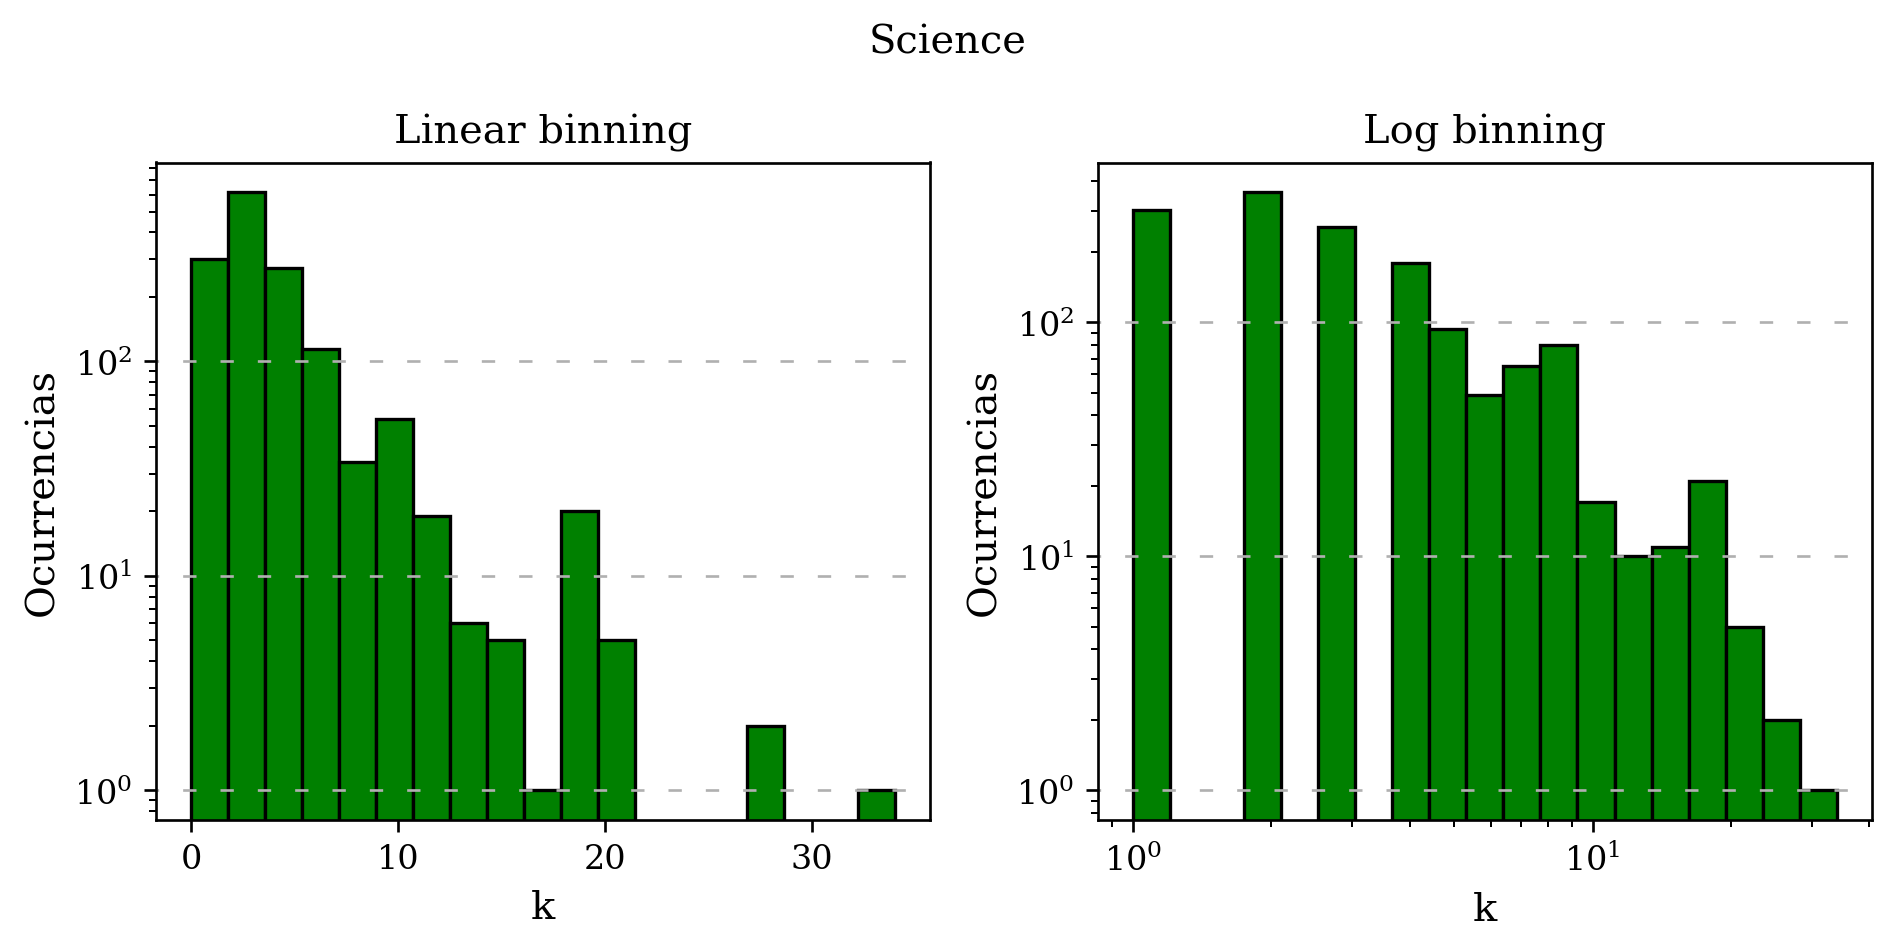

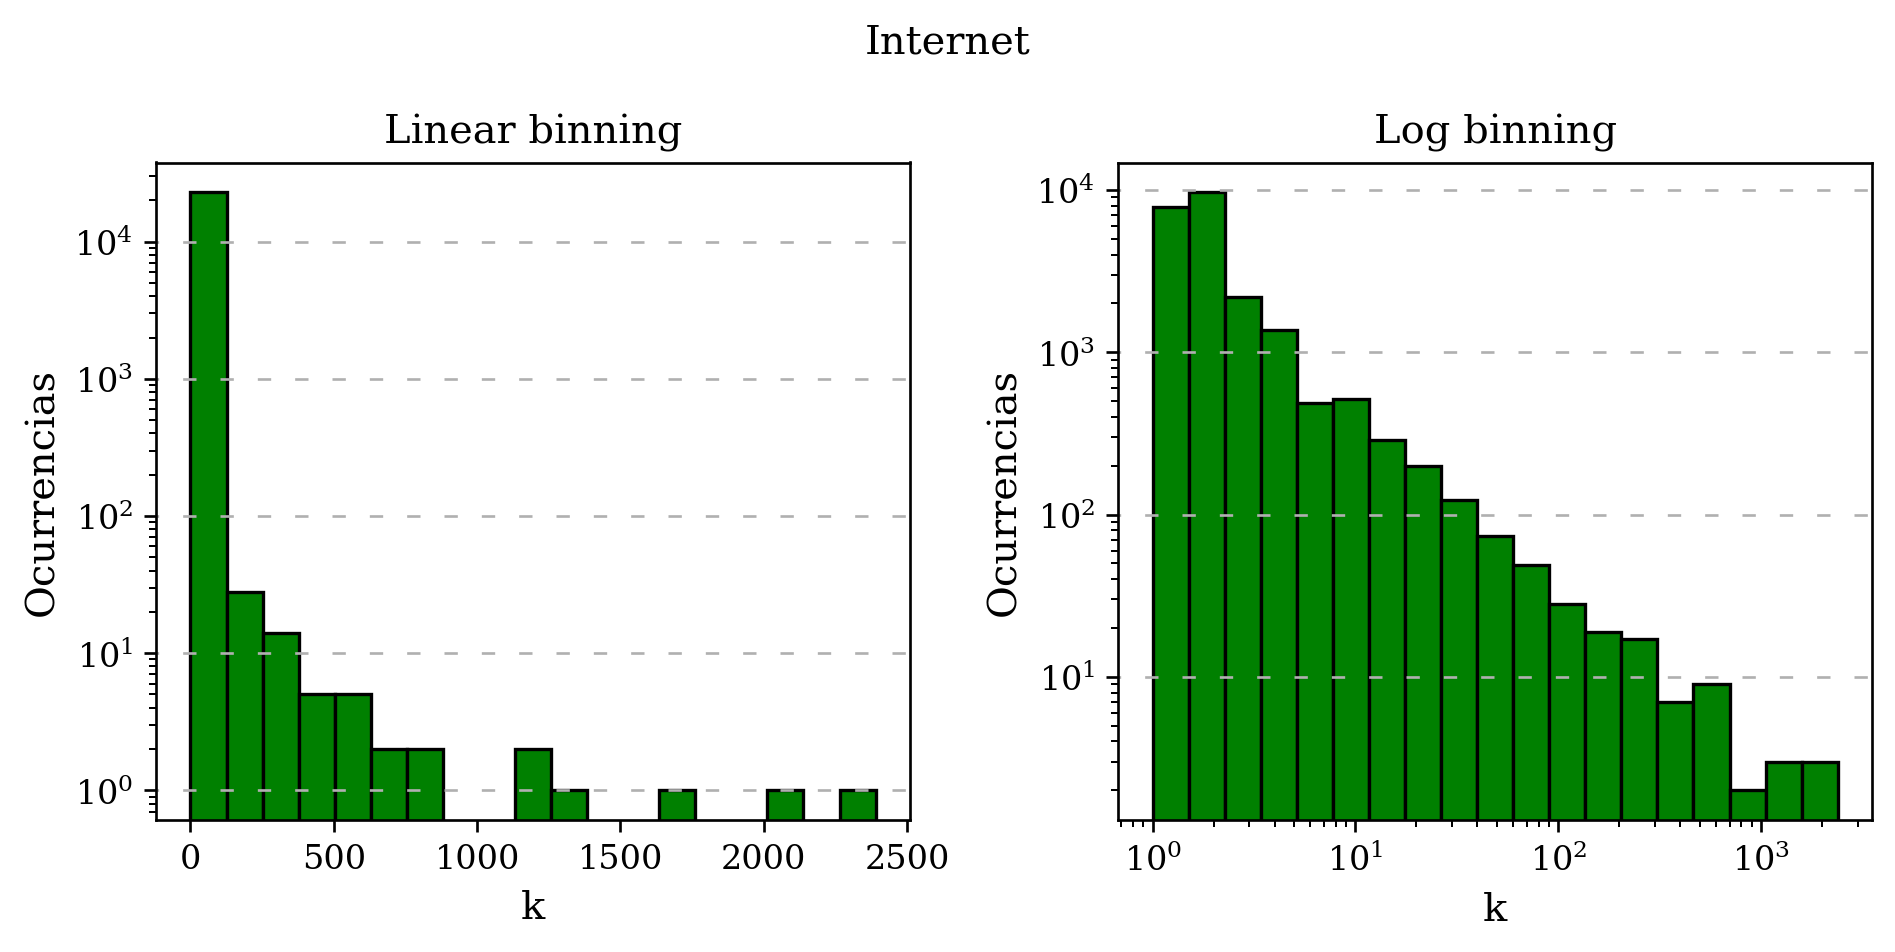

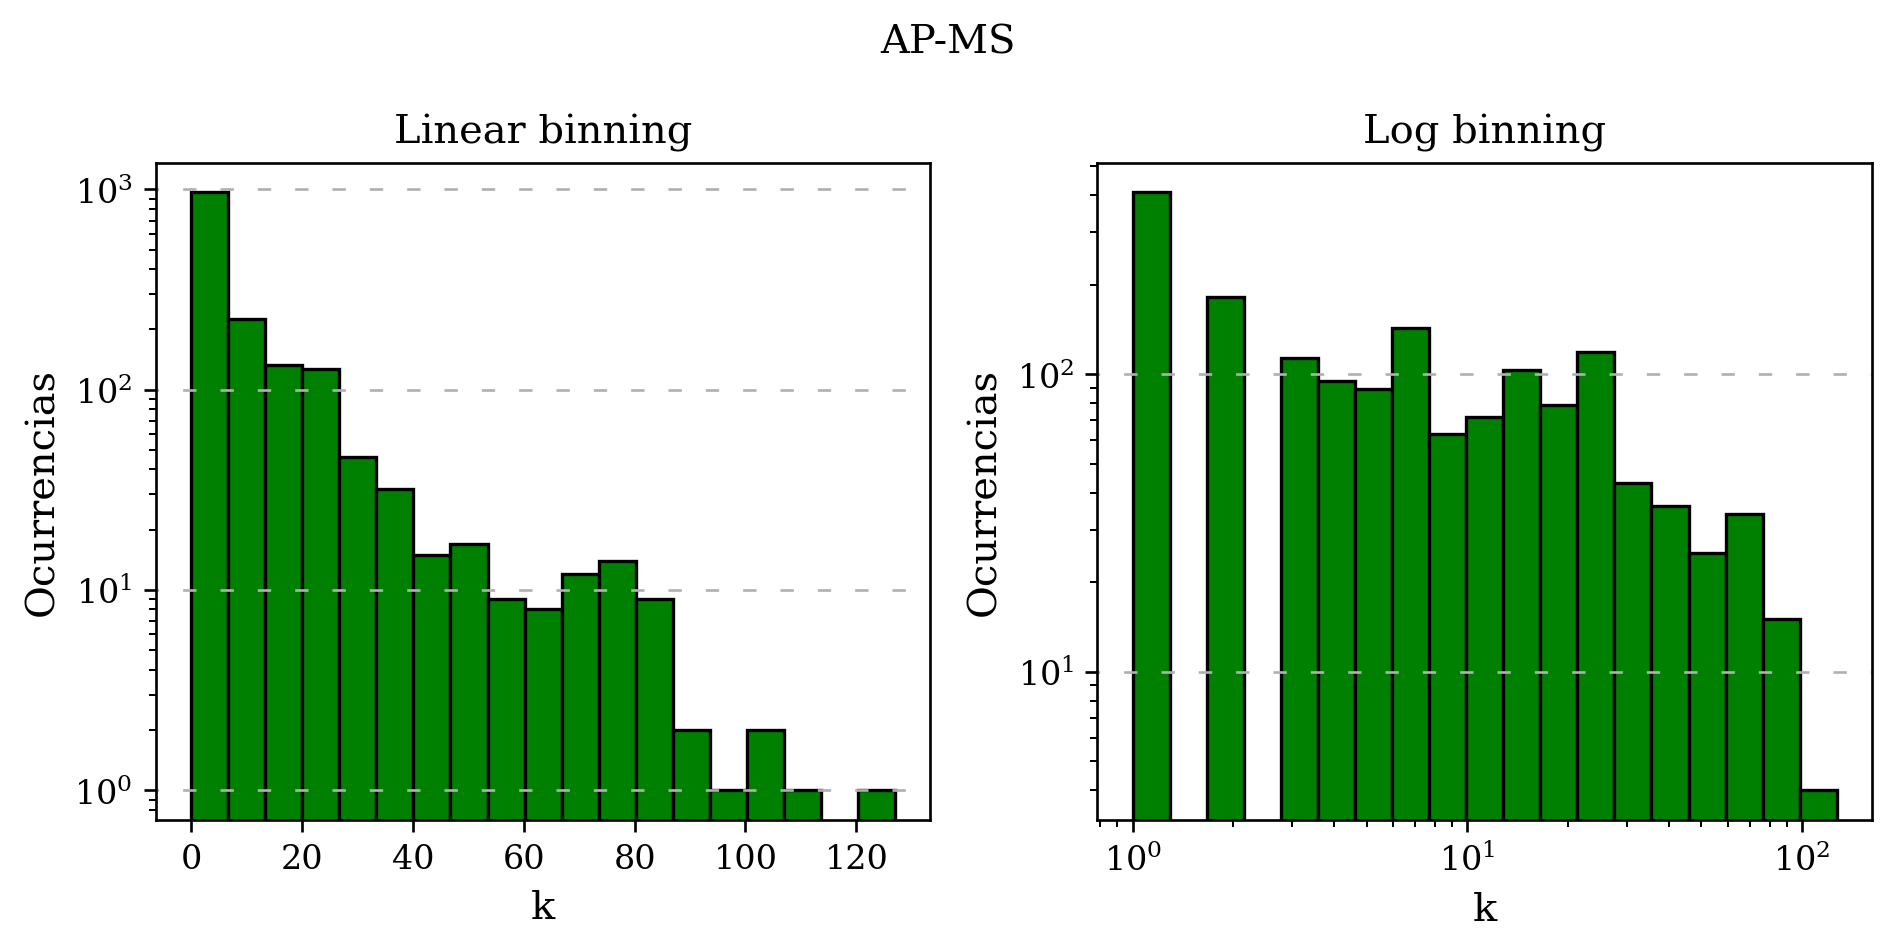

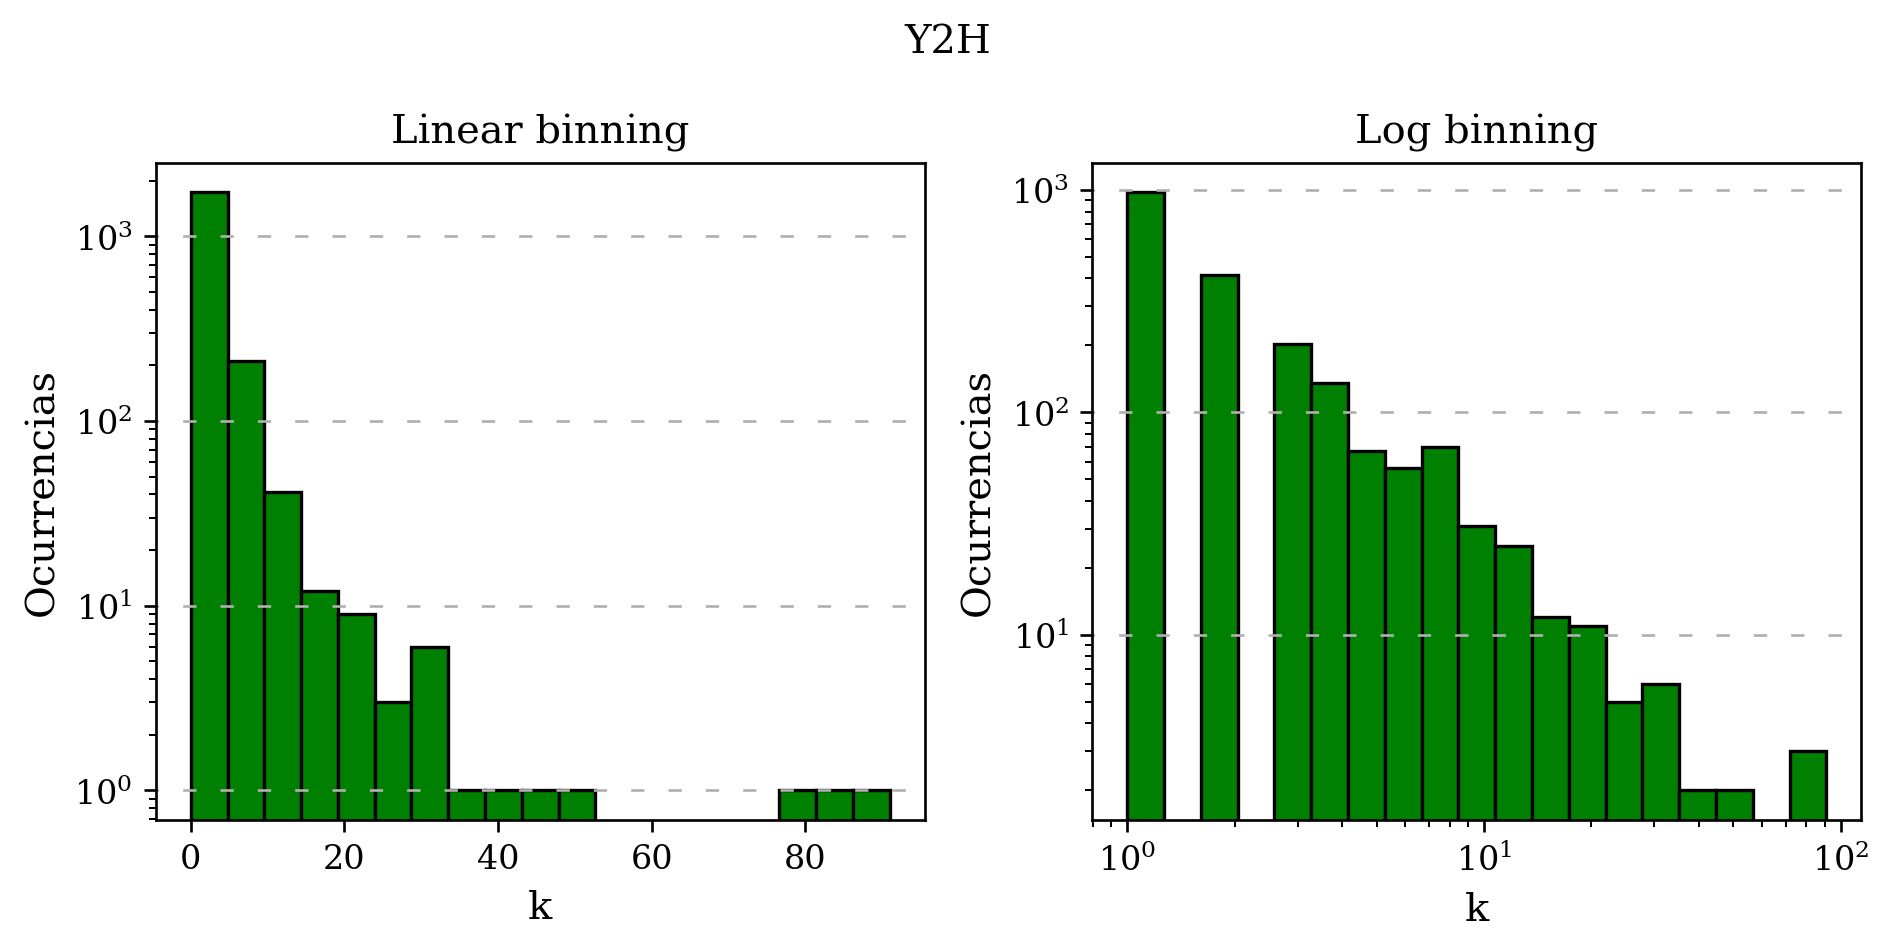

In [8]:
def plot_degree_dist(graph: nx.Graph, title: str):
    fig, ax = plt.subplots(1, 2, figsize=(8,4), tight_layout=True)

    lista_grados = list(dict(nx.degree(graph)).values())
    lin_bins = np.linspace(0, np.max(lista_grados), 20)
    log_bins = np.geomspace(1, np.max(lista_grados), 20)

    ax[0].hist(lista_grados, bins=lin_bins, edgecolor="black", color="green")
    ax[0].set_yscale("log")
    ax[0].set_xlabel('k')
    ax[0].set_ylabel("Ocurrencias")
    ax[0].set_title("Linear binning")
    ax[0].grid(axis="y", linestyle=(4, (5, 9)))
    
    ax[1].hist(lista_grados, bins=log_bins, edgecolor="black", color="green")
    ax[1].set_xscale("log")
    ax[1].set_yscale("log")
    ax[1].set_xlabel('k')
    ax[1].set_ylabel("Ocurrencias")
    ax[1].set_title("Log binning")
    ax[1].grid(axis="y", linestyle=(4, (5, 9)))
    
    fig.suptitle(title)
    plt.show()
    
for k, g in dict_graph.items():
    plot_degree_dist(g, k)

## Ajuste por una power-law. Discusión de resultados

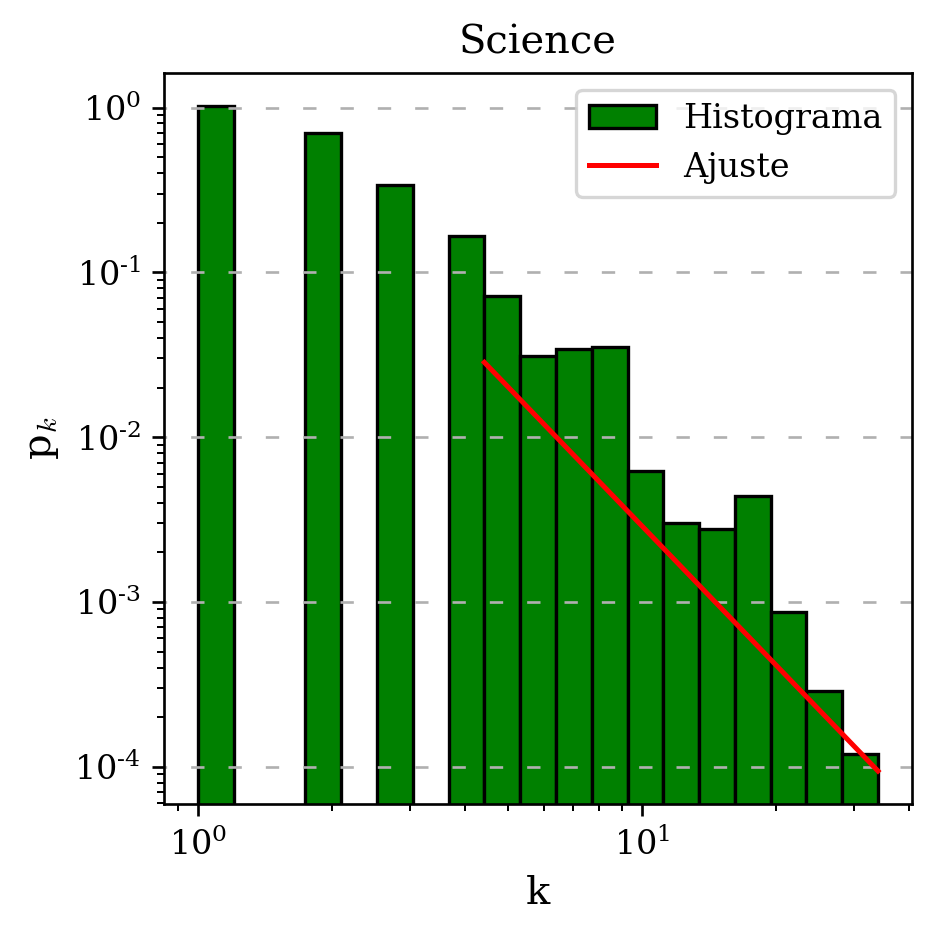

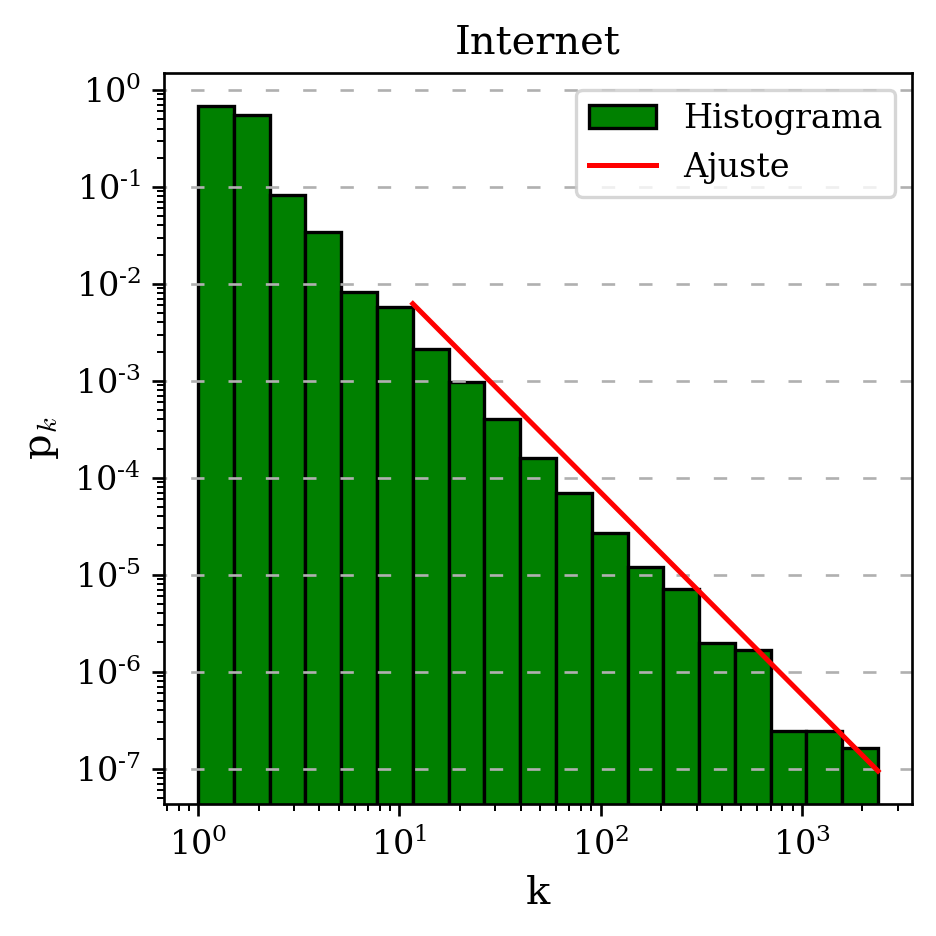

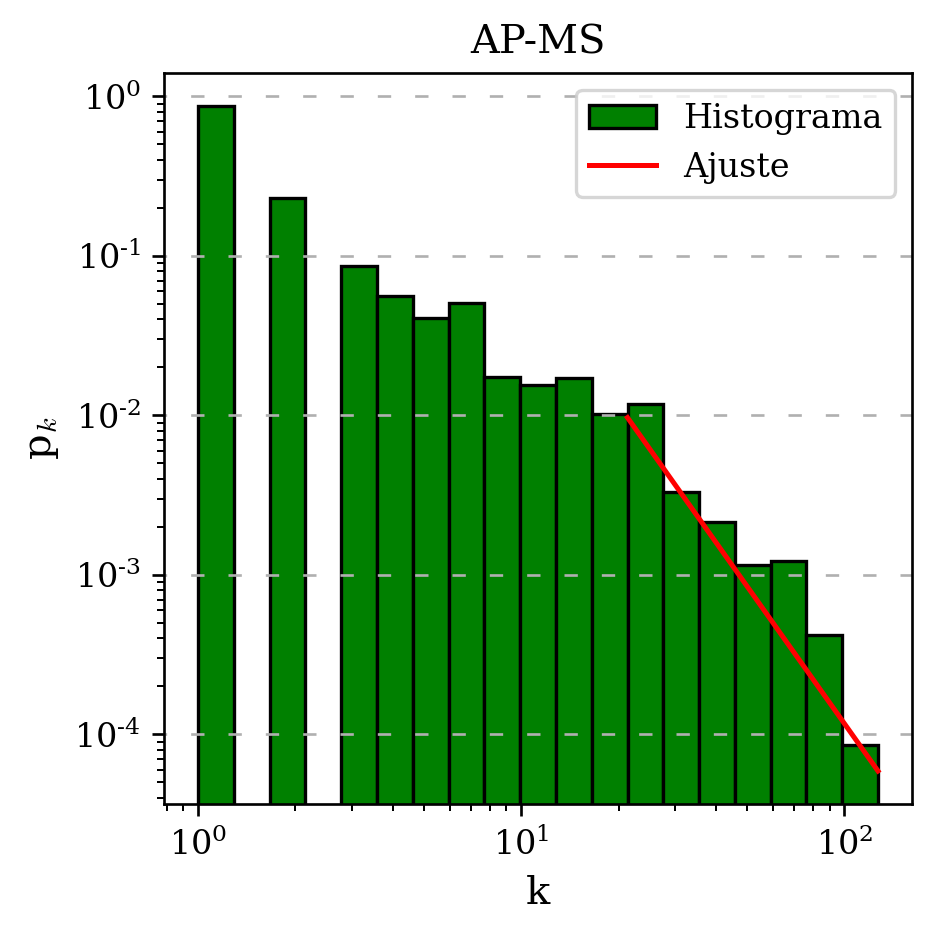

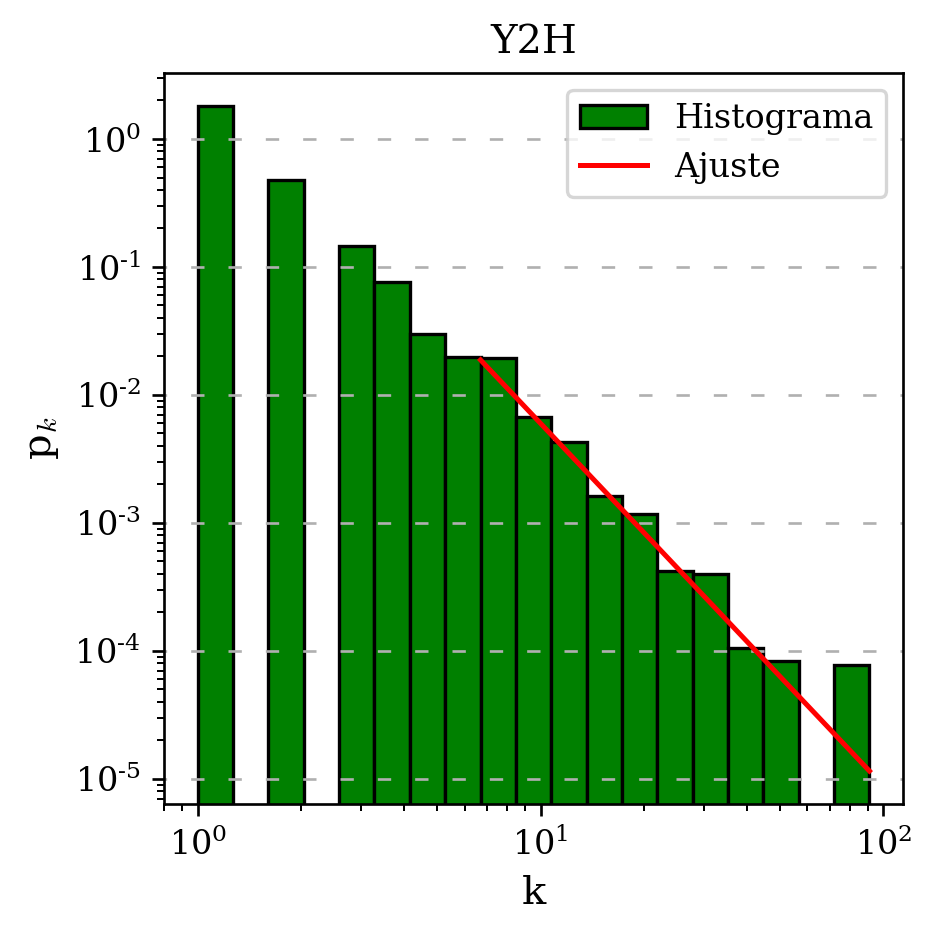

{'Science': {'Kmin': 4, 'gamma': 2.7964258918346436},
 'Internet': {'Kmin': 11, 'gamma': 2.085087172925074},
 'AP-MS': {'Kmin': 20, 'gamma': 2.857888899841521},
 'Y2H': {'Kmin': 6, 'gamma': 2.83212280641244}}

In [19]:
def fit_powerlaw(graph: nx.Graph, title: str, PLOT: bool = True, bins: int = 20):

    #Calculo de bins y grados
    lista_grados = list(dict(nx.degree(graph)).values())
    log_bins = np.geomspace(1, np.max(lista_grados), bins)
        
    #Ajuste
    fit = plfit(lista_grados)
    Kmin = fit._xmin #este sería nuestro Kmin
    gamma = fit._alpha #este sería nuestro gamma
    
    if PLOT:
        #Armado de histograma
        fig, ax = plt.subplots(1, 1, figsize=(4,4), tight_layout=True)
        hist = ax.hist(lista_grados, bins=log_bins, edgecolor="black", color="green", density=True, label="Histograma")
           
        #Gráfico de recta de ajuste
        norm = np.sum(hist[1]>Kmin)
        y = ((gamma-1)*Kmin**(gamma-1)*log_bins**-gamma)/norm
        ax.plot(log_bins[log_bins>Kmin],y[log_bins>Kmin], color="red", label="Ajuste")

        #Formato
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel('k')
        ax.set_ylabel("p$_k$")
        ax.set_title(title)
        ax.grid(axis="y", linestyle=(4, (5, 9))) 
        ax.legend()

        plt.show()
    
    return {"Kmin": Kmin, "gamma": gamma}

fit_params = {k: fit_powerlaw(g, k, PLOT=True) for k, g in dict_graph.items()}
fit_params

Acá iría el desarollo de las conclusiones.

# Ejercicio 2

## Análisis de asortatividad

Para ajustar $k_{nn}(k)$ se partió de:
$$k_{nn}(k) = a k^\mu$$
Tomando $log$ de ambos lados:
$$\log(k_{nn}) = \log(a k^\mu)$$
Utilizando propiedades de logaritmo sobre el lado izquierdo de la ecuación:
$$\log(k_{nn}) = \log(a) + \mu \; \log(k)$$
Por lo que renombrando $\alpha = \log(a)$, $\beta = \mu$:
$$\log(k_{nn}) = \alpha + \beta \; \log(k)$$
Es decir, podemos ajustar por una lineal tomando variable independiente $\log(k)$ y variable dependiente $\log(k_{nn})$

Entonces, luego uno puede graficar la función como: $f(k) = e^\beta \; k^\alpha$.
Alternativamente, vamos a ajustar directamente la exponencial para comparar la convergencia de los ajustes.

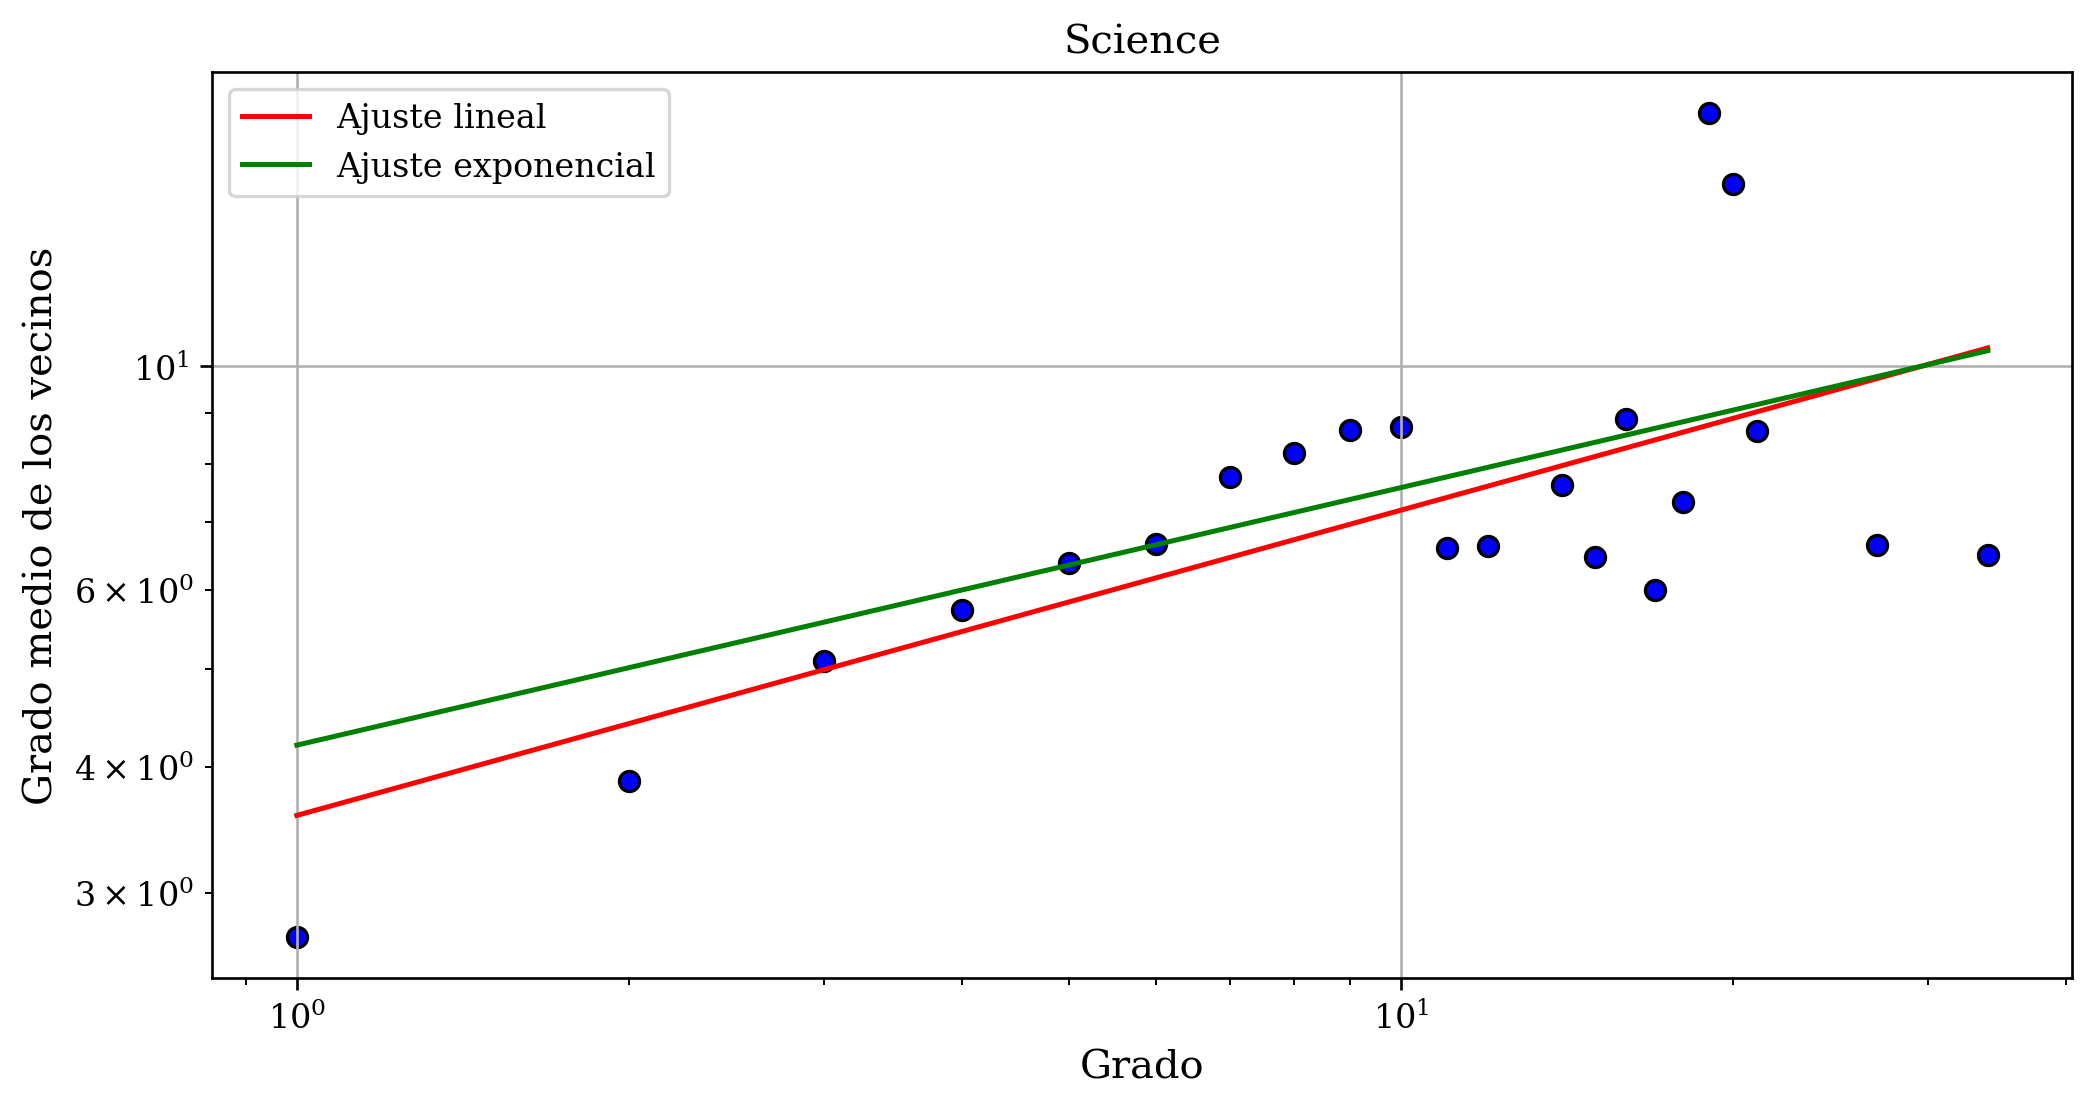

Parámetros óptimos del ajuste para la red 'Science':
            alpha = 0.3032576981086007
            beta = 1.2756455530135336
            a = 4.205282952475335
            mu = 0.2559042052658638
Asortividad de Newman para la red 'science': 0.4596424819185922




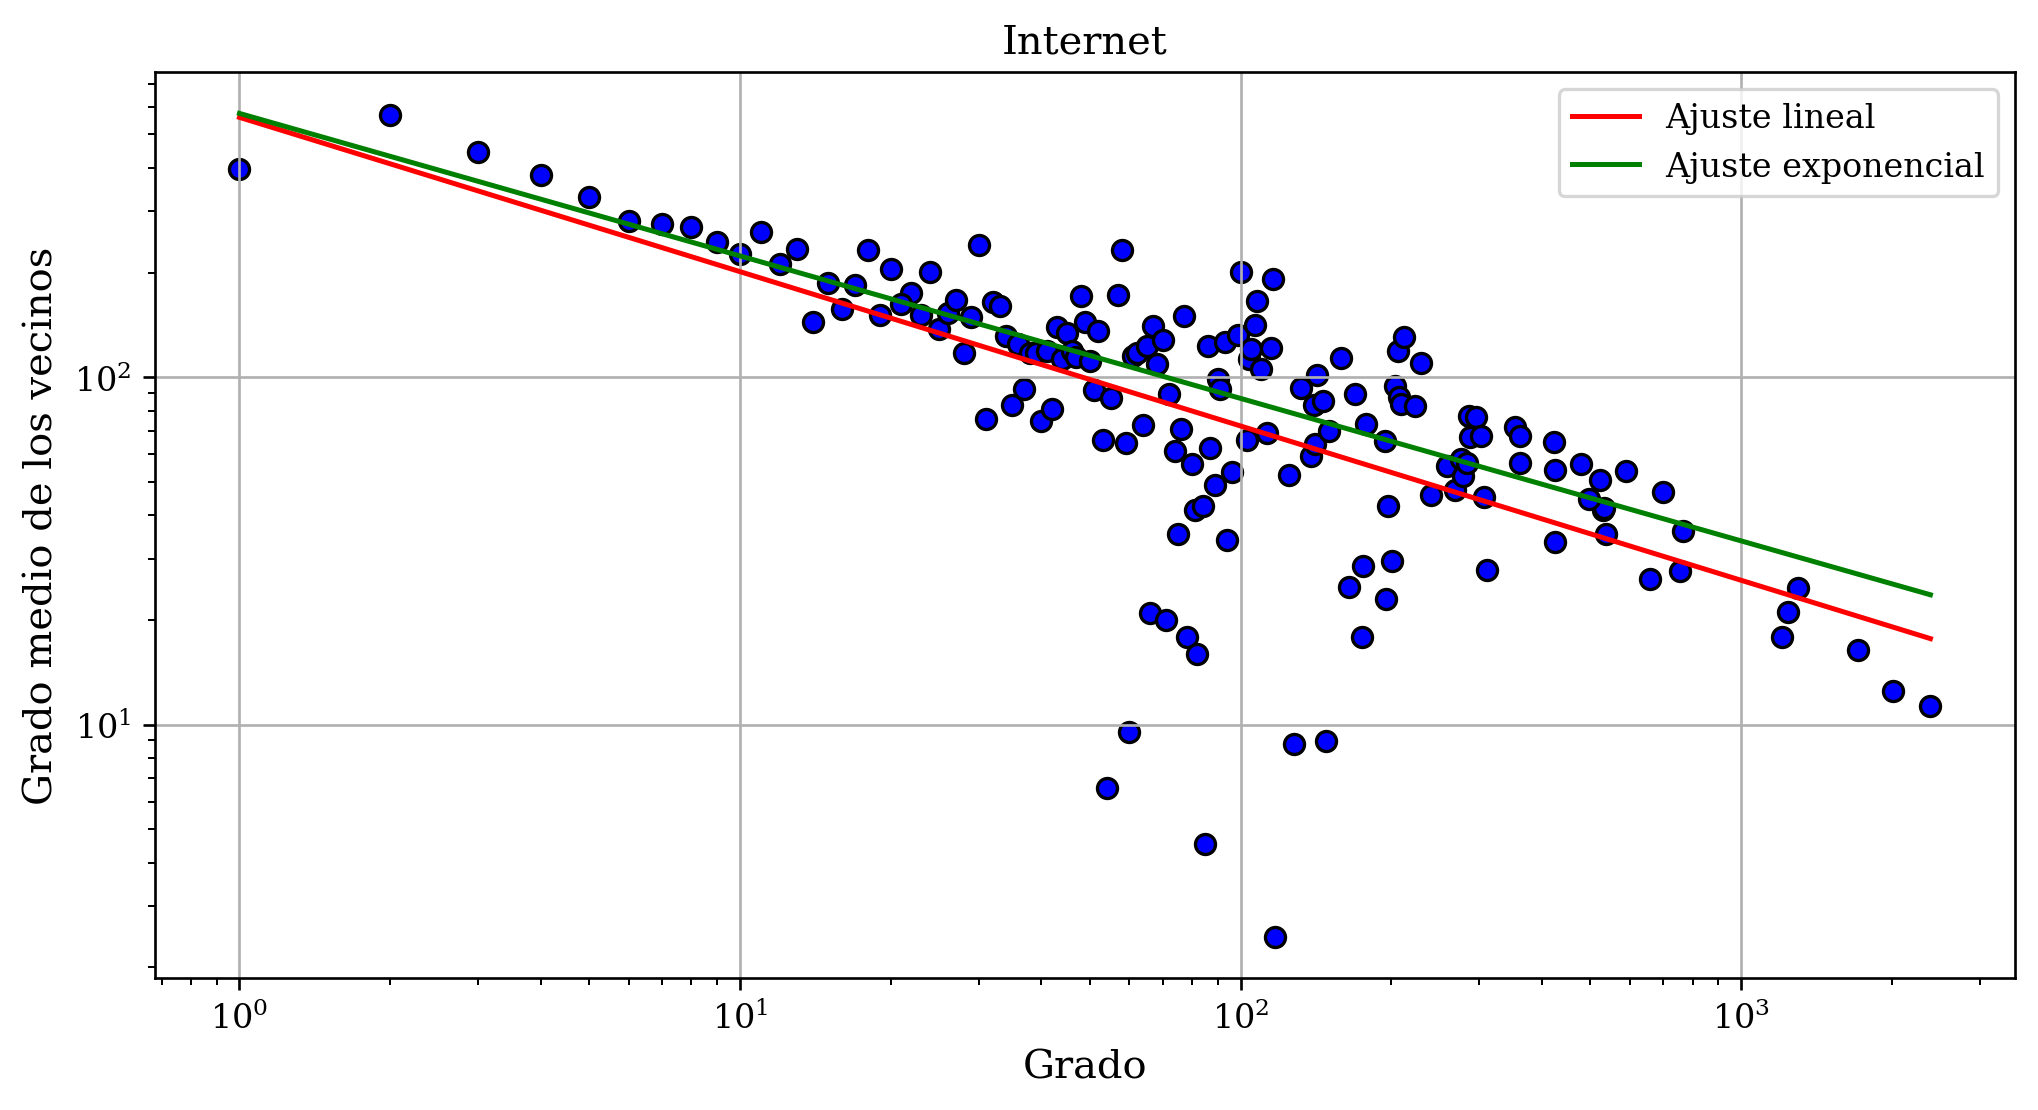

Parámetros óptimos del ajuste para la red 'Internet':
            alpha = -0.4442245228806794
            beta = 6.327758127359711
            a = 574.7189891419387
            mu = -0.410206840138086
Asortividad de Newman para la red 'internet': -0.19873552194552238


In [29]:
def analyze_asortivity(graph: nx.Graph, title: str = None, PLOT: bool = True, 
                       FIT: bool = True) -> tuple:
    """
    Método para analizar la asortividad de una red según lo enunciado en el Ejercicio 2.
    """
    
    degrees_dict = dict(nx.degree(graph)) #Dict con los grados como valor y los id como key.

    #Guardamos los nodos con mismo grado en una lista, dentro de un dict con el grado por key.
    id_by_degree = {}
    for cur_value in set(degrees_dict.values()):
        id_by_degree[cur_value] = [key for key, val in degrees_dict.items() if val == cur_value]

    #Almacena el promedio de los grados de los vecinos para los nodos de cada grado.
    mean_degree = {} #key: grado que estamos mirando, value: promedio de los grados

    for degree in id_by_degree.keys():
        degree_storage = [] #Almacena los grados de los nodos vecinos a cada nodo de grado 'degree'.

        #Iteramos sobre todos los nodos de grado 'degree'.
        for node in id_by_degree[degree]:
            #Guardamos los ids de los vecinos al nodo que miramos.
            neighbors_id = [n for n in nx.neighbors(graph, node)]
            #Guardamos los grados de los nodos vecinos al que miramos.
            neighbors_degree = [degrees_dict[i] for i in neighbors_id]
            degree_storage += neighbors_degree

        mean_degree[degree] = np.mean(degree_storage)
    
    k = np.array(list(mean_degree.keys()))
    knn = np.array(list(mean_degree.values()))  
        
    if FIT:
        #Fit log(k_nn) vs log(k) por lineal
        lin = lambda x, alpha, beta: alpha*x + beta
        popt_lin, pcov_lin = curve_fit(lin, np.log(k), np.log(knn))
        alpha, beta = popt_lin
        
        exp = lambda x, a, mu: a*x**mu
        popt_exp, pcov_exp = curve_fit(exp, k, knn)
        a, mu = popt_exp

        
    if PLOT:
        #Plot k_nn(k)
        fig, ax = plt.subplots(1, 1, figsize=(10,5))
        #ax.stem(k, knn, markerfmt="ko", linefmt="b-", basefmt="b-", label="$k_{nn}(k)$")
        ax.scatter(k, knn, edgecolor="black", color="blue")
        
        #Formato
        ax.grid()
        #ax.set_ylim(bottom=0)
        ax.set_xlabel("Grado")
        ax.set_ylabel("Grado medio de los vecinos")
        ax.set_xscale("log")
        ax.set_yscale("log")
        
        if title is not None:
            ax.set_title(title)
        
        if FIT:
            k_smooth =  np.linspace(np.min(k), np.max(k), 100)
            ax.plot(k_smooth, np.exp(beta)*k_smooth**alpha, label="Ajuste lineal", color="red")
            ax.plot(k_smooth, a*k_smooth**mu, label="Ajuste exponencial", color="green")

            plt.legend()
            plt.show()
            
            popt_dict = {"alpha": alpha, "beta": beta, "a": a, "mu": mu}
            
            print(f"""Parámetros óptimos del ajuste para la red '{title}':
            alpha = {popt_dict["alpha"]}
            beta = {popt_dict["beta"]}
            a = {popt_dict["a"]}
            mu = {popt_dict["mu"]}""")
        
        else:
    
            plt.legend()
            plt.show()
    
    
    if FIT:
        return mean_degree, popt_dict
    return mean_degree

def newman_asortivity(graph):
    """
    Cálculo de la asortividad de Newman dado un grafo.
    """
    nodes = list(graph.nodes())
    edges = list(graph.edges())
    degrees = dict(nx.degree(graph))
    degrees_arr = np.array(list(degrees.values()), dtype="int64")
    
    #Calculo de S1, S2, S3
    S1 = np.sum(degrees_arr)
    S2 = np.sum(degrees_arr**2)
    S3 = np.sum(degrees_arr**3)
    
    #Calculo de Se
    Se = 0
    for e in edges:
        Se += degrees[e[0]]*degrees[e[1]] 
    Se *= 2
    
    #Finalmente sumamos los resultados según la formula para r.
    r = (S1*Se - S2**2)/(S1*S3 - S2**2)
    
    return r

mean_degree_science, popt_science = analyze_asortivity(graph_science, "Science")
n_asortivity_science = newman_asortivity(graph_science)
print(f"Asortividad de Newman para la red 'science': {n_asortivity_science}\n", end = "\n"*2)

mean_degree_internet, popt_internet = analyze_asortivity(graph_internet, "Internet")
n_asortivity_internet = newman_asortivity(graph_internet)
print(f"Asortividad de Newman para la red 'internet': {n_asortivity_internet}")

Acá iria el desarrollo de las conclusiones de realizar estos dos cálculos.

## Repetimos para las redes Y2H y AP-MS

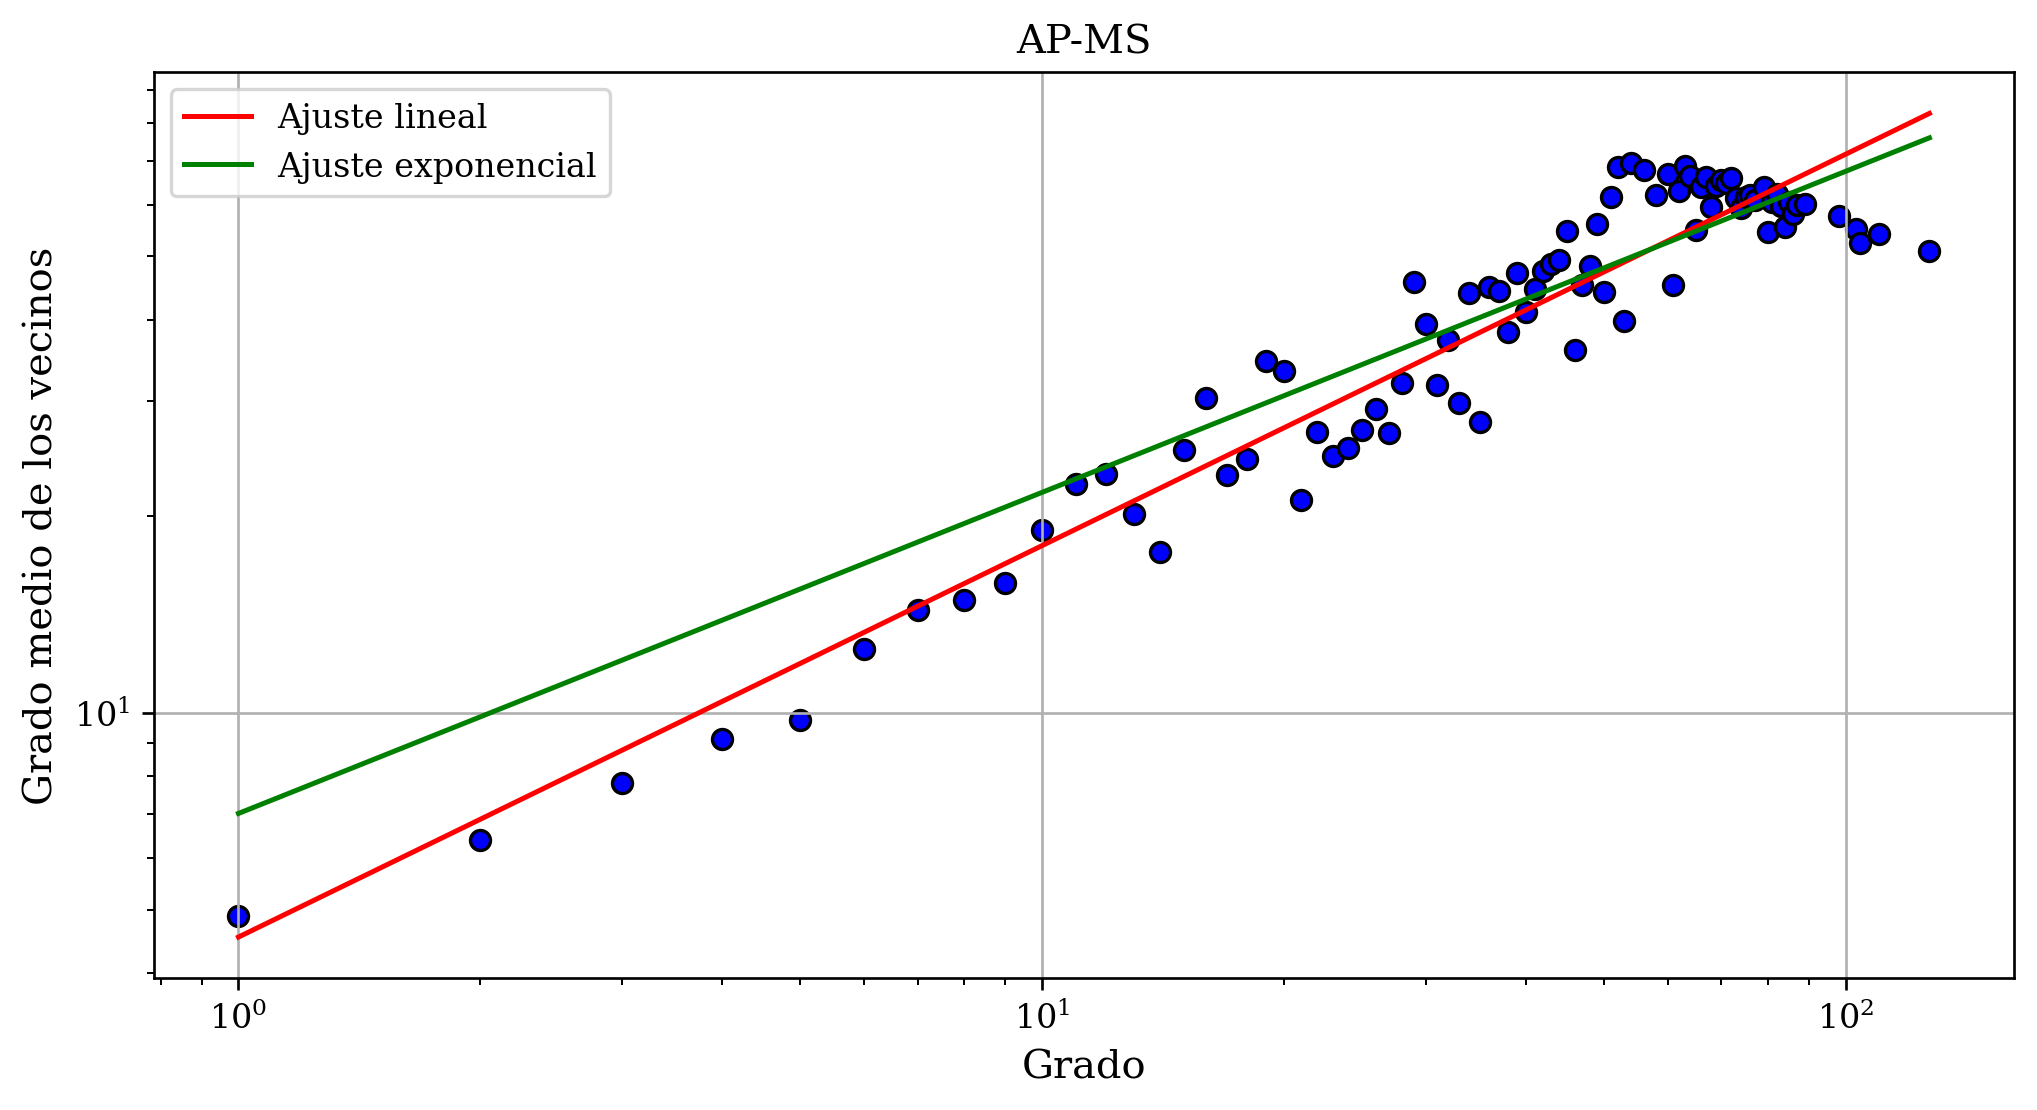

Parámetros óptimos del ajuste para la red 'AP-MS':
            alpha = 0.5992892370443036
            beta = 1.5125871125262242
            a = 7.0166259742652315
            mu = 0.4915749932369755
Asortividad de Newman para la red 'AP-MS': 0.6056742188944484




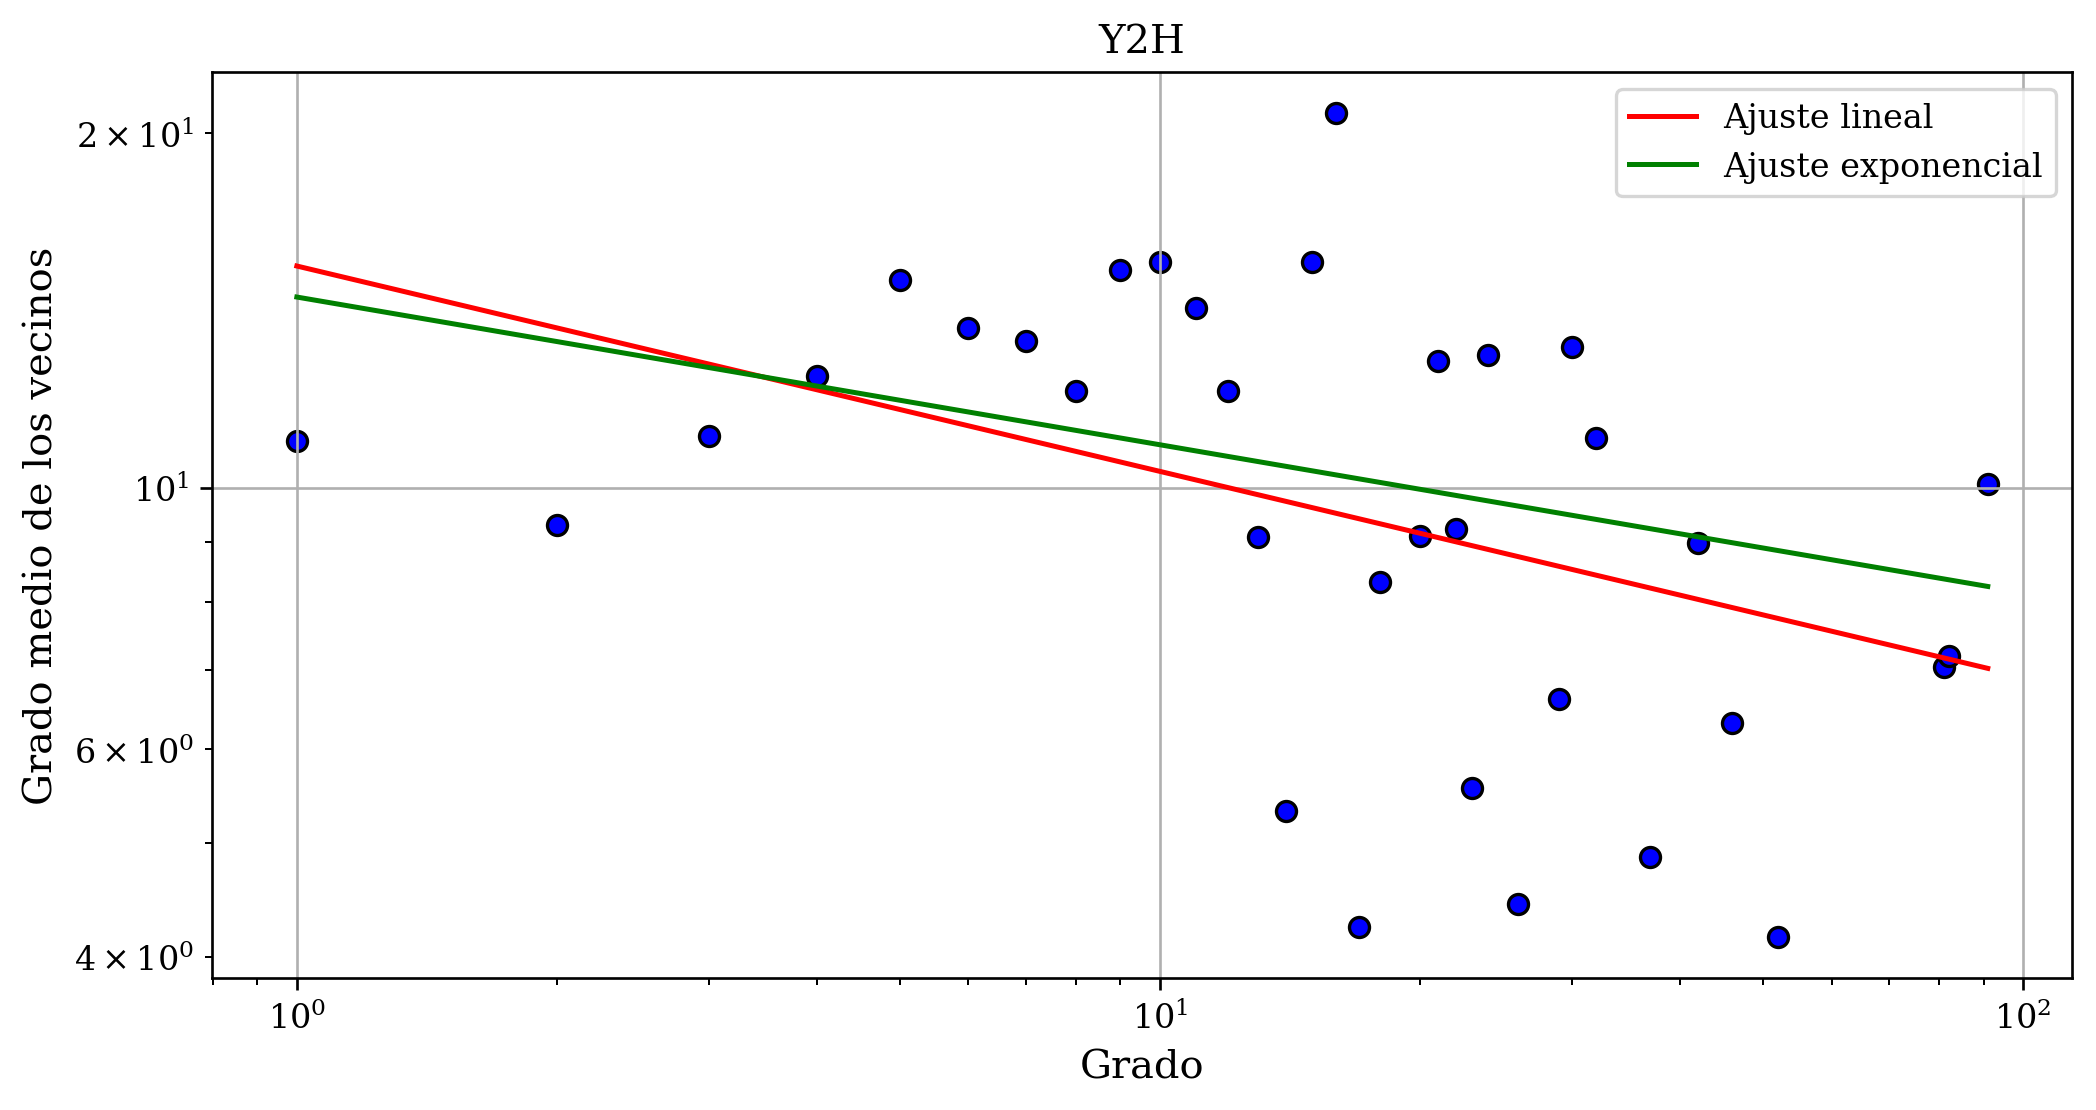

Parámetros óptimos del ajuste para la red 'Y2H':
            alpha = -0.17436816884449818
            beta = 2.736605062693829
            a = 14.526377302201498
            mu = -0.1254282272891496
Asortividad de Newman para la red 'Y2H': -0.041067211172400114


In [31]:
mean_degree_apms = analyze_asortivity(graph_apms, "AP-MS")
n_asortivity_apms = newman_asortivity(graph_apms)
print(f"Asortividad de Newman para la red 'AP-MS': {n_asortivity_apms}", end="\n"*3)

mean_degree_y2h = analyze_asortivity(graph_y2h, "Y2H")
n_asortivity_y2h = newman_asortivity(graph_y2h)
print(f"Asortividad de Newman para la red 'Y2H': {n_asortivity_y2h}")

Aca irían las conclusiones de correr los cálculos nuevamente para estas dos redes.